In [1]:
import numpy as np
import os
# from typing import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
from SGYReader import *
from demphing_analysis import *
import re
from numpy.fft import rfft, irfft

In [2]:
sgy_files = os.listdir('sgy_files/demphire_coord_table')
len(sgy_files)

45

In [3]:
params = []
for file in sgy_files:
    param = file.split('_')
    params.append({
        'L': int(param[3]),
        'DW': int(param[5]),
        'R': float(param[7])
    })

params.sort(key=lambda x: f"{x['L']}_{x['DW']}_{x['R']:.2e}")
for i in range(len(params)):
    print(f'{i}: {params[i]}')


0: {'L': 500, 'DW': 100, 'R': 0.0}
1: {'L': 500, 'DW': 100, 'R': 0.1}
2: {'L': 500, 'DW': 100, 'R': 0.01}
3: {'L': 500, 'DW': 100, 'R': 0.001}
4: {'L': 500, 'DW': 100, 'R': 0.0001}
5: {'L': 500, 'DW': 160, 'R': 0.0}
6: {'L': 500, 'DW': 160, 'R': 0.1}
7: {'L': 500, 'DW': 160, 'R': 0.01}
8: {'L': 500, 'DW': 160, 'R': 0.001}
9: {'L': 500, 'DW': 160, 'R': 0.0001}
10: {'L': 500, 'DW': 240, 'R': 0.0}
11: {'L': 500, 'DW': 240, 'R': 0.1}
12: {'L': 500, 'DW': 240, 'R': 0.01}
13: {'L': 500, 'DW': 240, 'R': 0.001}
14: {'L': 500, 'DW': 240, 'R': 0.0001}
15: {'L': 640, 'DW': 100, 'R': 0.0}
16: {'L': 640, 'DW': 100, 'R': 0.1}
17: {'L': 640, 'DW': 100, 'R': 0.01}
18: {'L': 640, 'DW': 100, 'R': 0.001}
19: {'L': 640, 'DW': 100, 'R': 0.0001}
20: {'L': 640, 'DW': 160, 'R': 0.0}
21: {'L': 640, 'DW': 160, 'R': 0.1}
22: {'L': 640, 'DW': 160, 'R': 0.01}
23: {'L': 640, 'DW': 160, 'R': 0.001}
24: {'L': 640, 'DW': 160, 'R': 0.0001}
25: {'L': 640, 'DW': 240, 'R': 0.0}
26: {'L': 640, 'DW': 240, 'R': 0.1}
27: {'L'

In [4]:
tensors_list = []
time_lines_list = []
time_evaluations_list = []
for param in params:
    tensor, time_line, time_evaluation = get_seysmic_tensor(os.path.join('sgy_files', 'demphire_coord_table'), exp=f'lamb_demphire_L_{param["L"]}_DW_{param["DW"]}_R_{param["R"]}_20_7')
    tensors_list.append(tensor)
    time_lines_list.append(time_line)
    time_evaluations_list.append(time_evaluation)
    if time_evaluation is None:
        print(f"Time evaluation is None for {param}")

2025-11-05 22:34:56,513 - SGYReader - INFO - Reading lamb_demphire_L_500_DW_100_R_0.0_20_7
2025-11-05 22:34:56,534 - SGYReader - INFO - Tensor shape: (26, 9103)
2025-11-05 22:34:56,535 - SGYReader - INFO - Userlog lamb_demphire_L_500_DW_100_R_0.0_20_7 uploaded
2025-11-05 22:34:56,536 - SGYReader - INFO - Time step lamb_demphire_L_500_DW_100_R_0.0_20_7: 0.000329563348
2025-11-05 22:34:56,538 - SGYReader - INFO - Calculation time lamb_demphire_L_500_DW_100_R_0.0_20_7: 716
2025-11-05 22:34:56,538 - SGYReader - INFO - Reading lamb_demphire_L_500_DW_100_R_0.1_20_7
2025-11-05 22:34:56,558 - SGYReader - INFO - Tensor shape: (26, 9103)
2025-11-05 22:34:56,559 - SGYReader - INFO - Userlog lamb_demphire_L_500_DW_100_R_0.1_20_7 uploaded
2025-11-05 22:34:56,559 - SGYReader - INFO - Time step lamb_demphire_L_500_DW_100_R_0.1_20_7: 0.000329563348
2025-11-05 22:34:56,561 - SGYReader - INFO - Calculation time lamb_demphire_L_500_DW_100_R_0.1_20_7: 1266
2025-11-05 22:34:56,562 - SGYReader - INFO - Read

Time evaluation is None for {'L': 500, 'DW': 160, 'R': 0.0}


2025-11-05 22:34:56,719 - SGYReader - INFO - Tensor shape: (26, 9307)
2025-11-05 22:34:56,720 - SGYReader - INFO - Userlog lamb_demphire_L_500_DW_160_R_0.001_20_7 uploaded
2025-11-05 22:34:56,720 - SGYReader - INFO - Time step lamb_demphire_L_500_DW_160_R_0.001_20_7: 0.000322346832
2025-11-05 22:34:56,722 - SGYReader - INFO - Calculation time lamb_demphire_L_500_DW_160_R_0.001_20_7: 886
2025-11-05 22:34:56,722 - SGYReader - INFO - Reading lamb_demphire_L_500_DW_160_R_0.0001_20_7
2025-11-05 22:34:56,742 - SGYReader - INFO - Tensor shape: (26, 9307)
2025-11-05 22:34:56,743 - SGYReader - INFO - Userlog lamb_demphire_L_500_DW_160_R_0.0001_20_7 uploaded
2025-11-05 22:34:56,744 - SGYReader - INFO - Time step lamb_demphire_L_500_DW_160_R_0.0001_20_7: 0.000322346832
2025-11-05 22:34:56,745 - SGYReader - INFO - Calculation time lamb_demphire_L_500_DW_160_R_0.0001_20_7: 990
2025-11-05 22:34:56,746 - SGYReader - INFO - Reading lamb_demphire_L_500_DW_240_R_0.0_20_7
2025-11-05 22:34:56,778 - SGYRea

## Analysis

In [75]:
640 / 369 + (640 - 640 / 369 * 250) / (250 + 192.25)

2.2011118924077877

640
Аналитическая скорость продольной волны: 376.43
Аналитическая скорость поперечной волны: 201.21
Аналитическая скорость Рэлеевской волны: 186.35
Временной шаг: 3.41e-04
Экспериментальная скорость поперечной волны: 250.00 м/с
Экспериментальная скорость отраженной продольной волны: 192.25 м/с
Величина ошибки: 1.10e-07
--------------------
Аналитическое время прихода продольной волны: 1.70 с
Экспериментальный индекс прихода продольной волны: 5102
Экспериментальное время прихода продольной волны: 1.74 с
Скорость пришедшей продольной волны: 368.09 м/с
Длины продольной волны в индексах: 1153
Длина продольной волны в метрах: 144.60 м
--------------------
Экспериментальное время пересечения волн: 2.20 с
Экспериментальный индекс пересечения волн: 6465
Экспериментальное расстояние пересечения волн: 550.75 м
Экспериментальный номер приемника, ближайшего к пересечению: 28
--------------------
Время прихода падающей волны через ресивер пересечения: 1.52 с
Индекс прихода падающей волны через реси

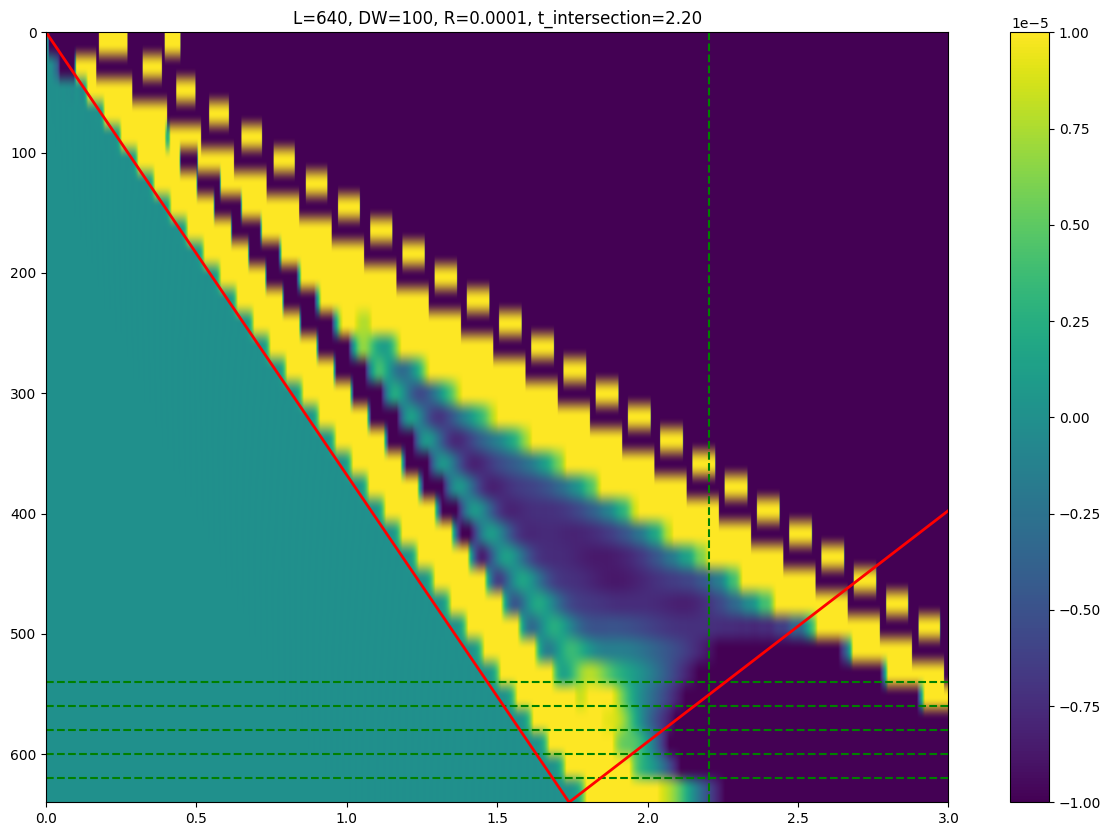

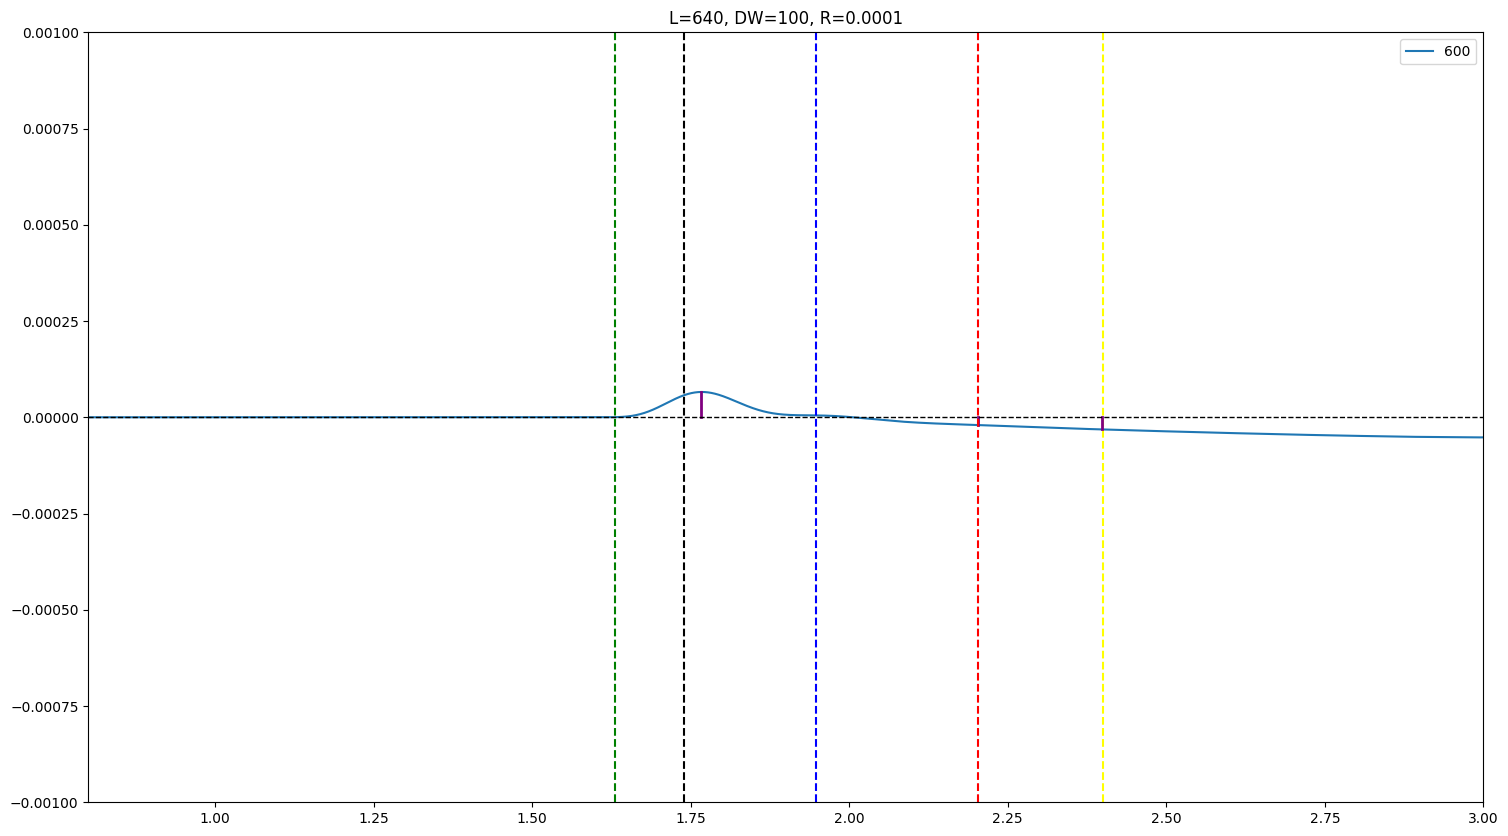

600: t_p_fall=1.630 t_p_refl=1.947 t_s_fall=2.400 | t_ints=2.203
amplitude_p_fall=6.575e-05 amplitude_p_refl_0=2.026e-05 | amplitude_p_refl_1=3.163e-05
ratio_0=30.82% ratio_1=48.11%
----


{30: {'t_p_fall': np.float64(1.6300541492746876),
  't_p_refl': np.float64(1.9467868446186178),
  't_s_fall': 2.4,
  'amplitude_p_fall': np.float32(6.574526e-05),
  'amplitude_p_refl_0': np.float32(2.0261374e-05),
  'amplitude_p_refl_1': np.float32(3.1627293e-05)}}

In [77]:
variable = 'Uy'
T_exp = 3

ind_plot = 19
L, DW, R = params[ind_plot]['L'], params[ind_plot]['DW'], params[ind_plot]['R']

receiver_visibility = np.array([False for _ in range(tensors_list[ind_plot][variable].shape[0])])

# receiver_visibility[-5] = True
# receiver_visibility[-4] = True
receiver_visibility[-3] = True
# receiver_visibility[-2] = True
# receiver_visibility[-1] = True

demphing_analysis(
    tensor=tensors_list[ind_plot][variable],
    time_line=time_lines_list[ind_plot],
    size_block=20,
    T_exp=T_exp,
    E=2e+8,
    nu=0.3,
    rho=1900,
    L=L,
    DW=DW,
    R=R,
    x_0=0.8,
    x_1=3,
    y_0=-1e-3,
    y_1=1e-3,
    epsilon_order=np.abs(tensors_list[ind_plot][variable]).max() / 1e2,
    receiver_visibility=receiver_visibility,
    plot_title=f'L={params[ind_plot]["L"]}, DW={params[ind_plot]["DW"]}, R={params[ind_plot]["R"]}',
    verbose=True
)

In [34]:
amplitudes_list = []

for ind_plot, param in enumerate(params):
    L, DW, R = param['L'], param['DW'], param['R']
    
    # if ind_plot > 14:
    #     continue
    # if ind_plot < 15 or ind_plot > 29:
    #     continue
    if ind_plot < 30 or ind_plot > 44:
        continue

    print(f"L={L}, DW={DW}, R={R}")

    # if L > 500:
    #     break

    receiver_visibility = np.array([False for _ in range(tensors_list[ind_plot][variable].shape[0])])

    # receiver_visibility[-5] = True
    # receiver_visibility[-4] = True
    receiver_visibility[-3] = True
    # receiver_visibility[-2] = True
    # receiver_visibility[-1] = True

    amplitudes = demphing_analysis(
        tensor=tensors_list[ind_plot][variable],
        time_line=time_lines_list[ind_plot],
        size_block=20,
        T_exp=T_exp,
        E=2e+8,
        nu=0.3,
        rho=1900,
        L=L,
        DW=DW,
        R=R,
        x_0=0.8,
        x_1=3,
        y_0=-1e-3,
        y_1=1e-3,
        epsilon_order=np.abs(tensors_list[ind_plot][variable]).max() / 1e2,
        receiver_visibility=receiver_visibility,
        plot_title=f'R={params[ind_plot]["R"]}, DW={params[ind_plot]["DW"]}, L={params[ind_plot]["L"]}',
        verbose=False
    )
    amplitudes_list.append([L, DW, R, amplitudes])

L=760, DW=100, R=0.0
760
Аналитическая скорость продольной волны: 376.43
Аналитическая скорость поперечной волны: 201.21
Аналитическая скорость Рэлеевской волны: 186.35
Временной шаг: 3.41e-04
Экспериментальная скорость поперечной волны: 250.00 м/с
Экспериментальная скорость отраженной продольной волны: 192.25 м/с
Величина ошибки: 3.49e-07
--------------------
Аналитическое время прихода продольной волны: 2.02 с
Экспериментальный индекс прихода продольной волны: 6035
Экспериментальное время прихода продольной волны: 2.06 с
Скорость пришедшей продольной волны: 369.54 м/с
Длины продольной волны в индексах: 2129
Длина продольной волны в метрах: 268.06 м
--------------------
Экспериментальное время пересечения волн: 2.61 с
Экспериментальный индекс пересечения волн: 7667
Экспериментальное расстояние пересечения волн: 653.13 м
Экспериментальный номер приемника, ближайшего к пересечению: 33
--------------------
Время прихода падающей волны через ресивер пересечения: 1.79 с
Индекс прихода пада

In [35]:
amplitudes_p_fall = {}
amplitudes_p_refl_0 = {}
amplitudes_p_refl_1 = {}

for amplitudes_obj in amplitudes_list:
    L, DW, R, amplitudes = amplitudes_obj
    print(f"L:{L}, DW:{DW}, R:{R}")
    for reciever in amplitudes.keys():
        amplitudes_p_fall[f"{L}_{DW}_{R}"] = amplitudes[reciever]["amplitude_p_fall"]
        amplitudes_p_refl_0[f"{L}_{DW}_{R}"] = amplitudes[reciever]["amplitude_p_refl_0"]
        amplitudes_p_refl_1[f"{L}_{DW}_{R}"] = amplitudes[reciever]["amplitude_p_refl_1"]
        
        print(f"{reciever}: \n\t{amplitudes[reciever]["amplitude_p_fall"]:.2e}\n\t{amplitudes[reciever]["amplitude_p_refl_0"]:.2e}\n\t{amplitudes[reciever]["amplitude_p_refl_1"]:.2e}")

L:760, DW:100, R:0.0
36: 
	8.00e-05
	1.47e-05
	1.47e-05
L:760, DW:100, R:0.1
36: 
	3.79e-05
	1.34e-05
	2.25e-05
L:760, DW:100, R:0.01
36: 
	4.25e-05
	1.50e-05
	2.58e-05
L:760, DW:100, R:0.001
36: 
	4.55e-05
	1.59e-05
	2.74e-05
L:760, DW:100, R:0.0001
36: 
	4.76e-05
	1.66e-05
	2.85e-05
L:760, DW:160, R:0.0
36: 
	8.00e-05
	1.47e-05
	1.47e-05
L:760, DW:160, R:0.1
36: 
	3.87e-05
	1.49e-05
	2.37e-05
L:760, DW:160, R:0.01
36: 
	4.34e-05
	1.69e-05
	2.76e-05
L:760, DW:160, R:0.001
36: 
	4.61e-05
	1.78e-05
	2.95e-05
L:760, DW:160, R:0.0001
36: 
	4.78e-05
	1.84e-05
	3.07e-05
L:760, DW:240, R:0.0
36: 
	8.00e-05
	1.47e-05
	1.47e-05
L:760, DW:240, R:0.1
36: 
	3.69e-05
	1.50e-05
	2.39e-05
L:760, DW:240, R:0.01
36: 
	4.04e-05
	1.68e-05
	2.80e-05
L:760, DW:240, R:0.001
36: 
	4.24e-05
	1.75e-05
	2.99e-05
L:760, DW:240, R:0.0001
36: 
	4.37e-05
	1.78e-05
	3.09e-05


In [36]:
L

760

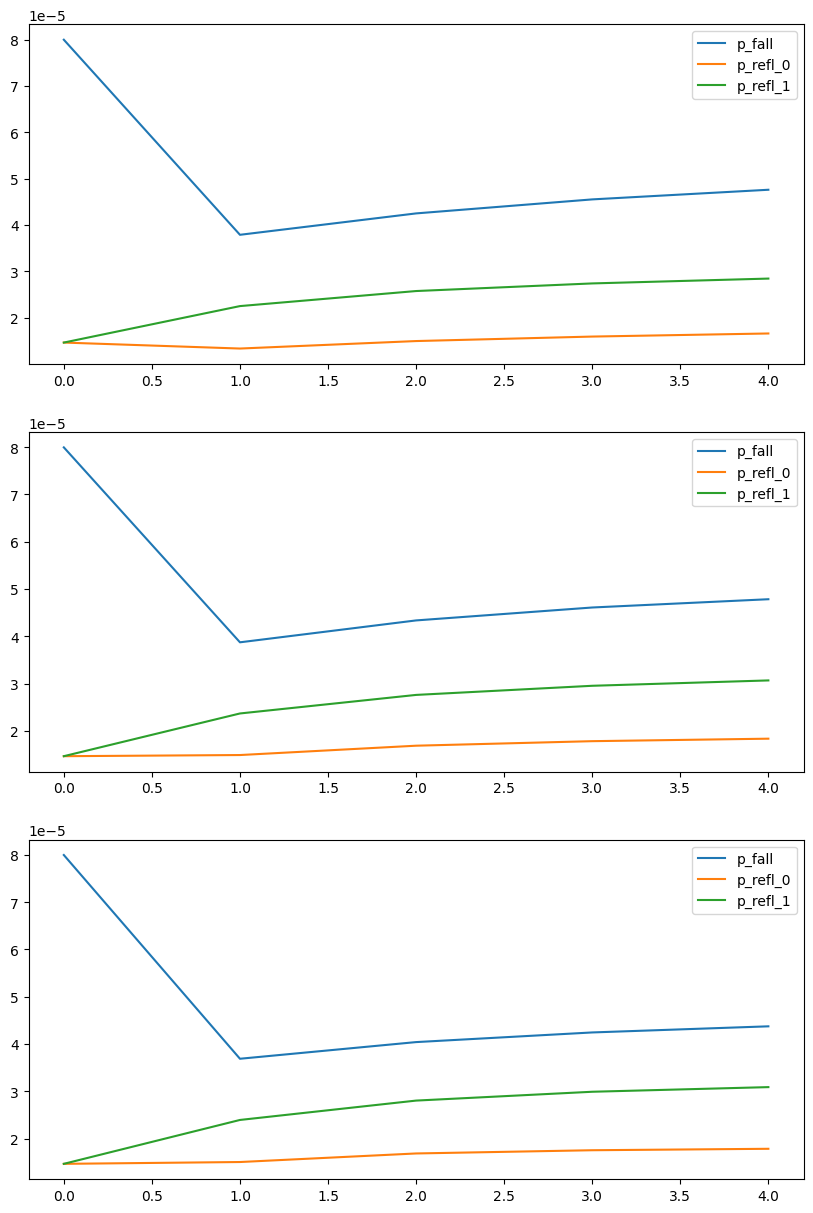

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for ind, DW in enumerate([100, 160, 240]):
    tmps_p_fall = []
    tmps_p_refl_0 = []
    tmps_p_refl_1 = []
    for R in [0.0, 0.1, 0.01, 0.001, 0.0001]:
        tmps_p_fall.append(amplitudes_p_fall[f"{L}_{DW}_{R}"])
        tmps_p_refl_0.append(amplitudes_p_refl_0[f"{L}_{DW}_{R}"])
        tmps_p_refl_1.append(amplitudes_p_refl_1[f"{L}_{DW}_{R}"])

    axs[ind].plot(tmps_p_fall, label='p_fall')
    axs[ind].plot(tmps_p_refl_0, label='p_refl_0')
    axs[ind].plot(tmps_p_refl_1, label='p_refl_1')
    axs[ind].legend()

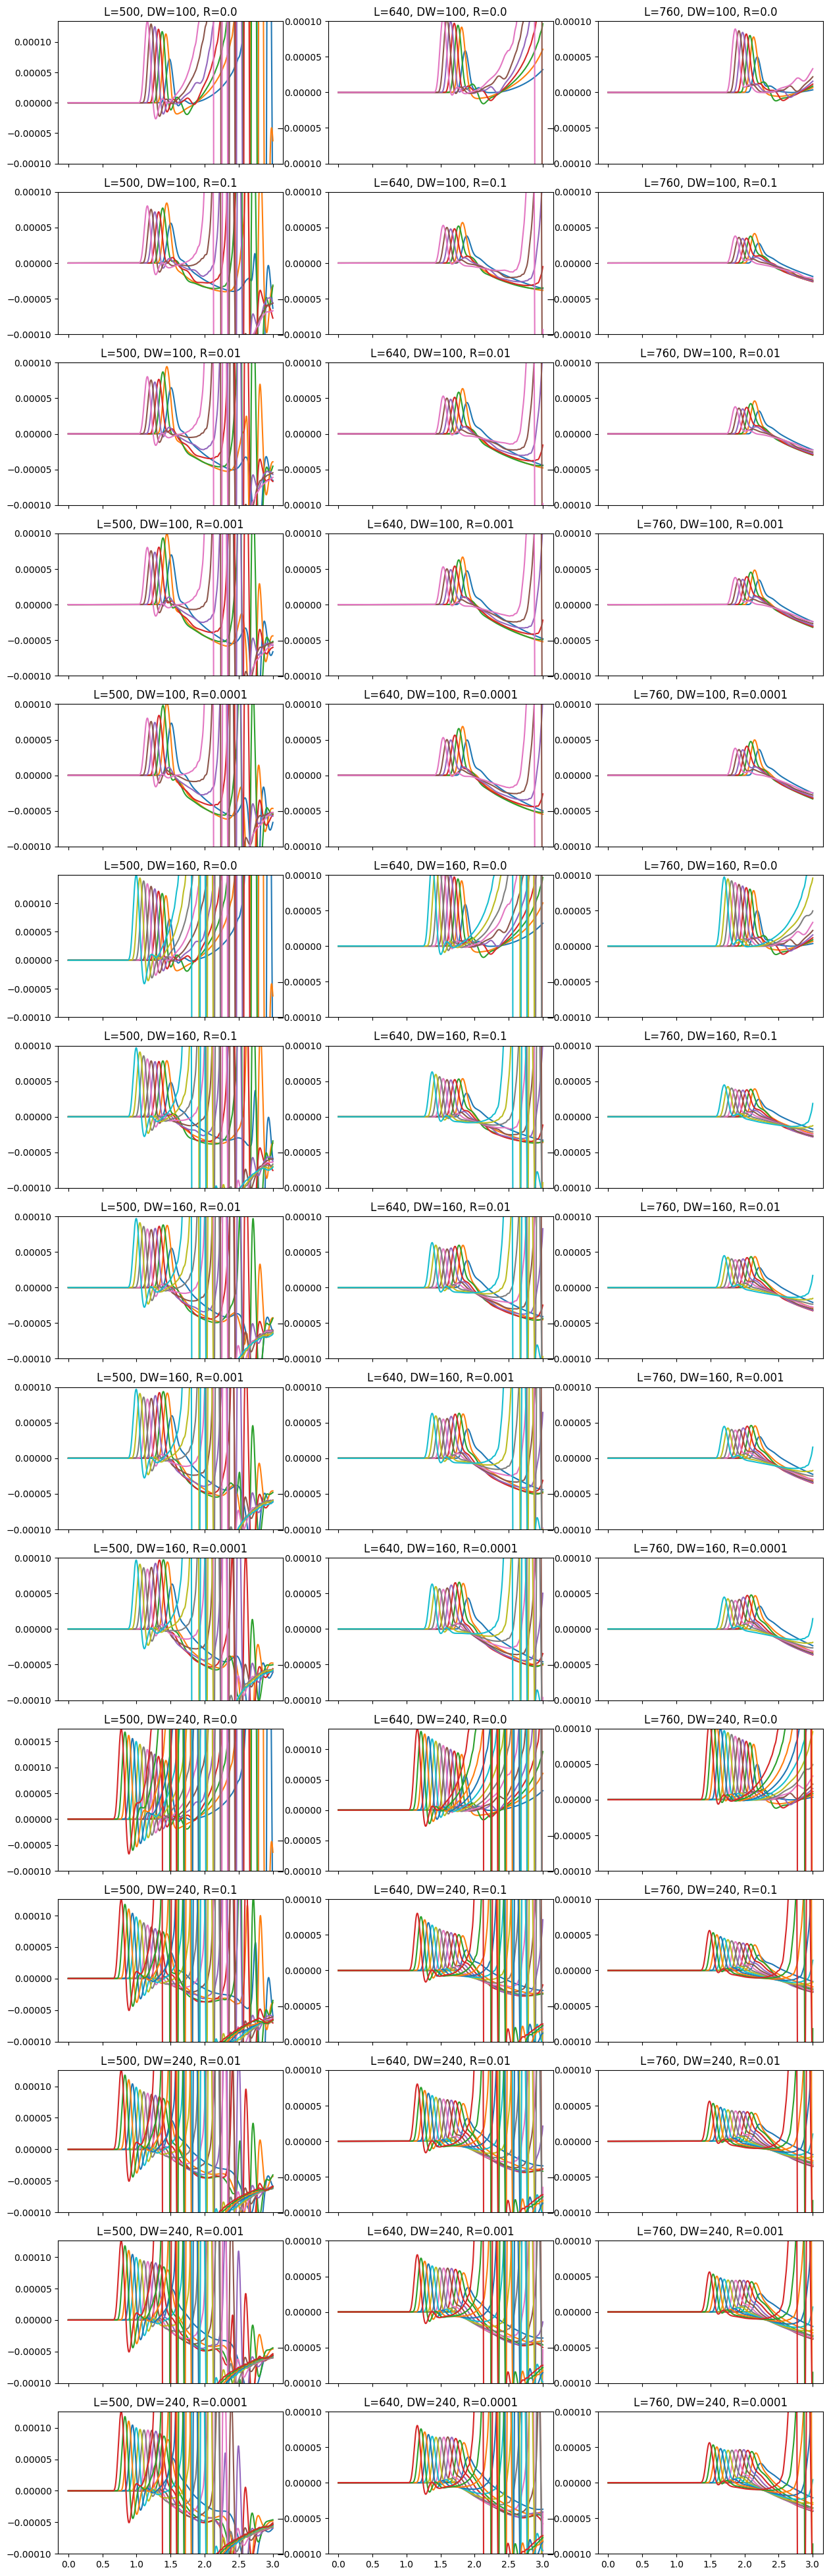

In [63]:
fig, axs = plt.subplots(15, 3, figsize=(15, 50), sharex=True)

for ind_p, param in enumerate(params):
    L, DW, R = param['L'], param['DW'], param['R']

    for reciever in range(1, DW // 20 + 3):
        axs[ind_p % 15, ind_p // 15].plot(
            time_lines_list[ind_p],
            tensors_list[ind_p]['Uy'][-reciever])
    N = tensors_list[ind_p]['Uy'].shape[-1]
    axs[ind_p % 15, ind_p // 15].set_title(f'L={L}, DW={DW}, R={R}')
    axs[ind_p % 15, ind_p // 15].set_ylim(-1e-4, max(1e-4, np.abs(tensors_list[ind_p]['Uy'][-reciever, :int(1.2 / 3 * N)]).max()))

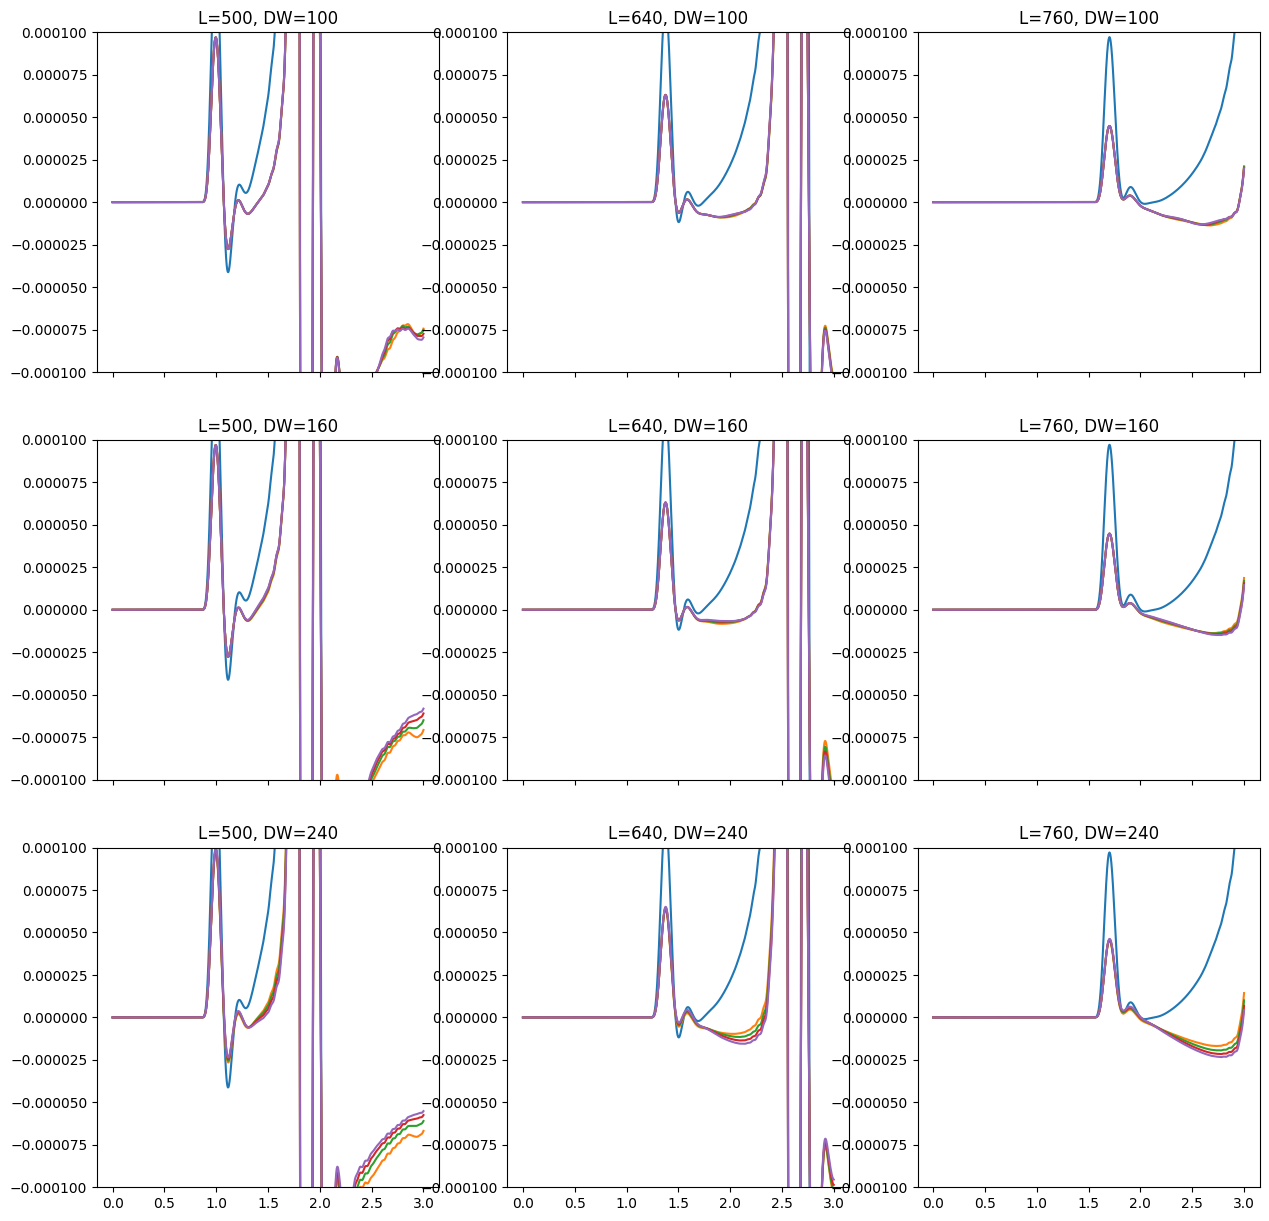

In [79]:
reciever = -10

fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True)

for ind_p, param in enumerate(params):
    L, DW, R = param['L'], param['DW'], param['R']

    tmp = ind_p // 5
    axs[tmp % 3, tmp // 3].plot(
        time_lines_list[ind_p],
        tensors_list[ind_p]['Uy'][reciever])
    N = tensors_list[ind_p]['Uy'].shape[-1]
    axs[tmp % 3, tmp // 3].set_title(f'L={L}, DW={DW}')
    axs[tmp % 3, tmp // 3].set_ylim(-1e-4, max(1e-4, np.abs(tensors_list[ind_p]['Uy'][reciever, :int(1.2 / 3 * N)]).max()))

In [ ]:
param

[{'L': 500, 'DW': 100, 'R': 0.0},
 {'L': 500, 'DW': 100, 'R': 0.1},
 {'L': 500, 'DW': 100, 'R': 0.01},
 {'L': 500, 'DW': 100, 'R': 0.001},
 {'L': 500, 'DW': 100, 'R': 0.0001},
 {'L': 500, 'DW': 160, 'R': 0.0},
 {'L': 500, 'DW': 160, 'R': 0.1},
 {'L': 500, 'DW': 160, 'R': 0.01},
 {'L': 500, 'DW': 160, 'R': 0.001},
 {'L': 500, 'DW': 160, 'R': 0.0001},
 {'L': 500, 'DW': 240, 'R': 0.0},
 {'L': 500, 'DW': 240, 'R': 0.1},
 {'L': 500, 'DW': 240, 'R': 0.01},
 {'L': 500, 'DW': 240, 'R': 0.001},
 {'L': 500, 'DW': 240, 'R': 0.0001},
 {'L': 640, 'DW': 100, 'R': 0.0},
 {'L': 640, 'DW': 100, 'R': 0.1},
 {'L': 640, 'DW': 100, 'R': 0.01},
 {'L': 640, 'DW': 100, 'R': 0.001},
 {'L': 640, 'DW': 100, 'R': 0.0001},
 {'L': 640, 'DW': 160, 'R': 0.0},
 {'L': 640, 'DW': 160, 'R': 0.1},
 {'L': 640, 'DW': 160, 'R': 0.01},
 {'L': 640, 'DW': 160, 'R': 0.001},
 {'L': 640, 'DW': 160, 'R': 0.0001},
 {'L': 640, 'DW': 240, 'R': 0.0},
 {'L': 640, 'DW': 240, 'R': 0.1},
 {'L': 640, 'DW': 240, 'R': 0.01},
 {'L': 640, 'DW':

In [10]:
raise Exception('stop')

Exception: stop

(-1e-05, 1e-05)

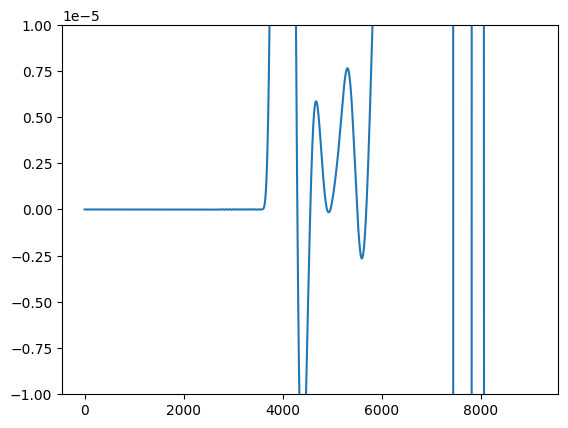

In [ ]:
plt.plot(tensors_list[ind_plot][variable][-4])
plt.ylim(-1e-5, 1e-5)

In [ ]:
find_border(tensors_list[ind_plot]['Uy'][-4], ths=1e-5)[2] / N * T_exp

1.91475337800725

7113

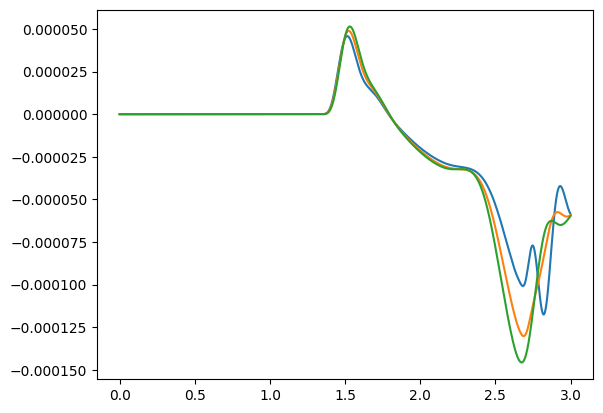

In [ ]:
plt.plot(np.arange(tensors_list[12]['Uy'].shape[-1]) / tensors_list[12]['Uy'].shape[-1] * T_exp, tensors_list[12]['Uy'][-1])
plt.plot(np.arange(tensors_list[13]['Uy'].shape[-1]) / tensors_list[13]['Uy'].shape[-1] * T_exp, tensors_list[13]['Uy'][-1])
plt.plot(np.arange(tensors_list[14]['Uy'].shape[-1]) / tensors_list[14]['Uy'].shape[-1] * T_exp, tensors_list[14]['Uy'][-1])
# plt.ylim(-1e-5, 1e-5)

(-1e-05, 1e-05)

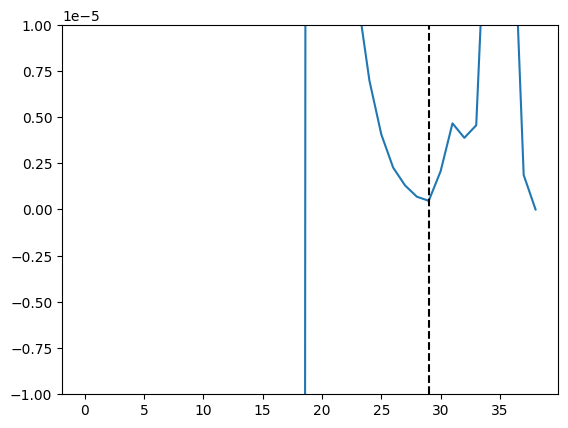

In [ ]:
plt.plot(tensors_list[12]['Uy'][:, int(tensors_list[12]['Uy'].shape[-1] * 2 / 3)])
plt.axvline(x=29, color='black', linestyle='--')
plt.ylim(-1e-5, 1e-5)

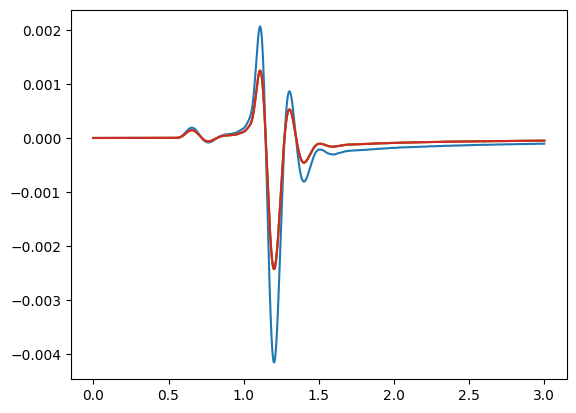

In [ ]:
rec = 10
plt.plot(np.arange(tensors_list[16]['Uy'].shape[-1]) / tensors_list[16]['Uy'].shape[-1] * T_exp, tensors_list[16]['Uy'][rec])
plt.plot(np.arange(tensors_list[17]['Uy'].shape[-1]) / tensors_list[17]['Uy'].shape[-1] * T_exp, tensors_list[17]['Uy'][rec])
plt.plot(np.arange(tensors_list[18]['Uy'].shape[-1]) / tensors_list[18]['Uy'].shape[-1] * T_exp, tensors_list[18]['Uy'][rec])
plt.plot(np.arange(tensors_list[19]['Uy'].shape[-1]) / tensors_list[19]['Uy'].shape[-1] * T_exp, tensors_list[19]['Uy'][rec])

In [ ]:
M = np.abs(tensors_list[12]['Uy'][20]).max() / 20
M

np.float32(7.077154e-05)

In [ ]:
m = np.abs(tensors_list[12]['Uy'][35, :N // 2]).max() / 20
m

np.float32(1.696017e-10)

(-0.0001, 0.0001)

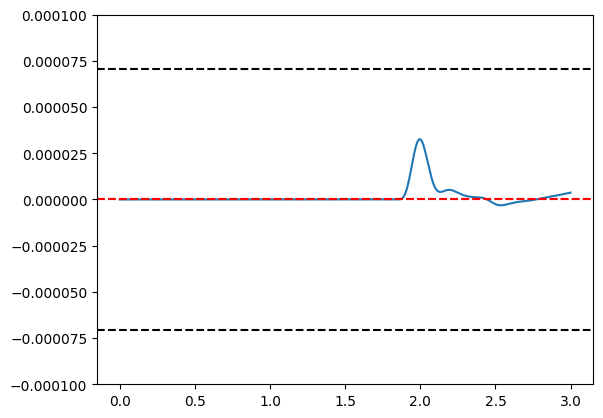

In [ ]:
plt.plot(np.arange(tensors_list[12]['Uy'].shape[-1]) / tensors_list[12]['Uy'].shape[-1] * T_exp, tensors_list[12]['Uy'][35])
plt.axhline(y=m, color='red', linestyle='--')
plt.axhline(y=-m, color='red', linestyle='--')

plt.axhline(y=M, color='black', linestyle='--')
plt.axhline(y=-M, color='black', linestyle='--')

plt.ylim(-1e-4, 1e-4)

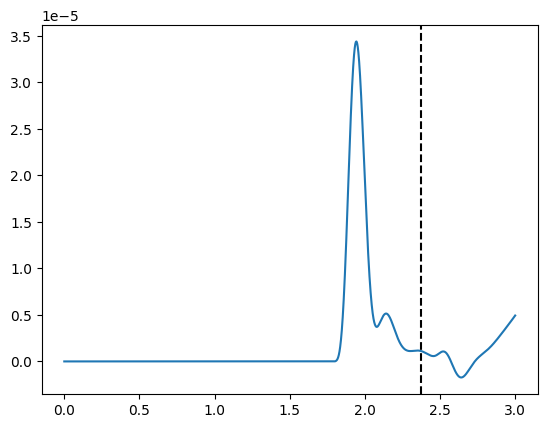

In [ ]:
plt.plot(np.arange(tensors_list[12]['Uy'].shape[-1]) / tensors_list[12]['Uy'].shape[-1] * T_exp, tensors_list[12]['Uy'][34])
plt.axvline(x=2.375, color='black', linestyle='--')
# plt.axhline(y=-m, color='black', linestyle='--')

In [ ]:
rb = int(2.8 / 3 * tensors_list[ind_plot]['Uy'].shape[-1])
a = np.max(np.abs(tensors_list[ind_plot]['Uy'][33, :6900]))
b = np.max(np.abs(tensors_list[ind_plot]['Uy'][34, 6900:rb]))
print(rb, a, b, b/a*100)

8410 3.631797e-05 1.7266057e-06 4.7541356


In [ ]:
plt.pl

In [ ]:
len(tensors_list[0]), tensors_list[0]['Uy'].shape

(6, (26, 9103))

In [ ]:
bias = 12
for i in range(3):
    for variable in tensors_list[bias + i].keys():
        print(i, variable, np.abs(tensors_list[bias + i][variable] - tensors_list[bias + (i+1) % 3][variable]).sum())
    print('--------')

0 Ux 2.1790446e-14
0 Uy 3.805116e-15
0 Vx 1.0767357e-10
0 Vy 1.0175132e-10
0 Ax 9.556609e-08
0 Ay 1.3702947e-07
--------
1 Ux 2.1036455e-14
1 Uy 7.8154714e-16
1 Vx 1.06932074e-10
1 Vy 2.9744034e-11
1 Ax 8.780532e-08
1 Ay 1.0996501e-07
--------
2 Ux 2.102082e-14
2 Uy 4.0835933e-15
2 Vx 1.4126444e-10
2 Vy 8.607162e-11
2 Ax 1.0701415e-07
2 Ay 1.11133005e-07
--------


(-8e-05, 8e-05)

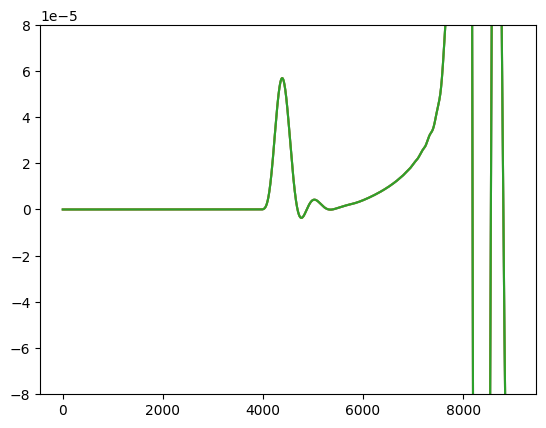

In [ ]:
plt.plot(tensors_list[12]['Uy'][25])
plt.plot(tensors_list[13]['Uy'][25])
plt.plot(tensors_list[14]['Uy'][25])
plt.ylim(-8*1e-5, 8*1e-5)

In [ ]:
print(left_border / tensors_list[ind][variable].shape[1] * T_exp, right_border / tensors_list[ind][variable].shape[1] * T_exp)

1.6609880749574106 2.176533219761499


In [ ]:
raise Exception('stop')

Exception: stop

In [ ]:
tensors_list = []
time_lines_list = []
time_evaluations_list = []
for R in ['0', '01', '001', '0001']:
    tensor, time_line, time_evaluation = get_seysmic_tensor(os.path.join('sgy_files'), exp=f'lamb_demphire_R_{R}_20_7')
    tensors_list.append(tensor)
    time_lines_list.append(time_line)
    time_evaluations_list.append(time_evaluation)


2025-10-30 13:46:39,327 - SGYReader - INFO - Reading lamb_demphire_R_0_20_7
2025-10-30 13:46:39,348 - SGYReader - INFO - Tensor shape: (26, 9103)
2025-10-30 13:46:39,350 - SGYReader - INFO - Userlog lamb_demphire_R_0_20_7 uploaded
2025-10-30 13:46:39,351 - SGYReader - INFO - Time step lamb_demphire_R_0_20_7: 0.000329563348
2025-10-30 13:46:39,352 - SGYReader - INFO - Calculation time lamb_demphire_R_0_20_7: 2973
2025-10-30 13:46:39,353 - SGYReader - INFO - Reading lamb_demphire_R_01_20_7
2025-10-30 13:46:39,372 - SGYReader - INFO - Tensor shape: (26, 9103)
2025-10-30 13:46:39,373 - SGYReader - INFO - Userlog lamb_demphire_R_01_20_7 uploaded
2025-10-30 13:46:39,373 - SGYReader - INFO - Time step lamb_demphire_R_01_20_7: 0.000329563348
2025-10-30 13:46:39,375 - SGYReader - INFO - Calculation time lamb_demphire_R_01_20_7: 2948
2025-10-30 13:46:39,375 - SGYReader - INFO - Reading lamb_demphire_R_001_20_7
2025-10-30 13:46:39,394 - SGYReader - INFO - Tensor shape: (26, 9103)
2025-10-30 13:46

# Updated

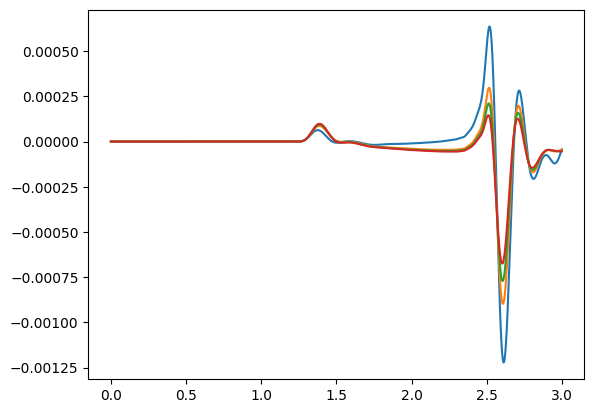

In [ ]:
T_exp = 3
plt.plot(np.arange(tensors_list[0]['Uy'].shape[-1]) / tensors_list[0]['Uy'].shape[-1] * T_exp, tensors_list[0]['Uy'][-3])
plt.plot(np.arange(tensors_list[1]['Uy'].shape[-1]) / tensors_list[1]['Uy'].shape[-1] * T_exp, tensors_list[1]['Uy'][-3])
plt.plot(np.arange(tensors_list[2]['Uy'].shape[-1]) / tensors_list[2]['Uy'].shape[-1] * T_exp, tensors_list[2]['Uy'][-3])
plt.plot(np.arange(tensors_list[3]['Uy'].shape[-1]) / tensors_list[3]['Uy'].shape[-1] * T_exp, tensors_list[3]['Uy'][-3])

In [ ]:
## FFT

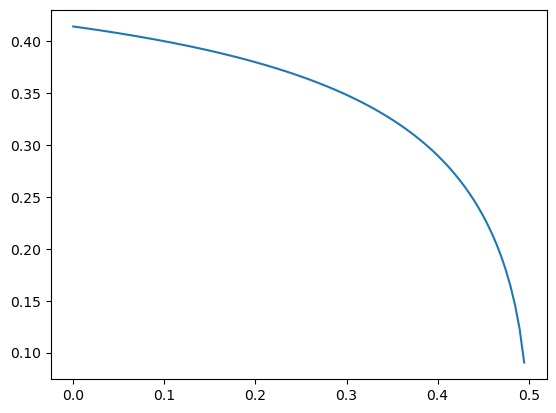

In [ ]:
nu_values = np.arange(100) / 200
plt.plot(nu_values, 1 / (np.sqrt(1 + 1 / (1 - 2 * nu_values)) + 1), label="nu = 0.01")

In [ ]:
def F(t, w):
    A = 1e+8
    w0 = 2 * np.pi * w
    w1 = w0 / np.sqrt(3)
    term_1 = A * w1**2 * np.exp(-w1 * t) / 4
    term_2 = np.sin(w0 * t) * (-t**2 / w1 + t / w1**2 + 1 / w1**3)
    term_3 = np.sqrt(3) * np.cos(w0 * t) * (t**2 / w1 + t / w1**2)

    return term_1 * (term_2 - term_3)

In [ ]:
def fft_F(omega, w):
    A = 1e+8
    w0 = 2 * np.pi * w
    w1 = w0 / np.sqrt(3)
    
    beta_m = w1 + (omega - w0) * 1j
    beta_p = w1 + (omega + w0) * 1j

    term_1 = -w1 / 4j * (1 / beta_m**3 - 1 / beta_p**3)
    term_2 = 1 / 8j * (1 / beta_m**2 - 1 / beta_p**2)
    term_3 = 1 / (w1 * 8j) * (1 / beta_m - 1 / beta_p)

    term_4 = w1 / 4 * (1 / beta_m**3 + 1 / beta_p**3)
    term_5 = 1 / 8 * (1 / beta_m**2 + 1 / beta_p**2)

    return A * (term_1 + term_2 + term_3 - np.sqrt(3) * (term_4 + term_5)) / np.sqrt(2 * np.pi)

Text(0.5, 1.0, 'Cumsum of FFT Berlage')

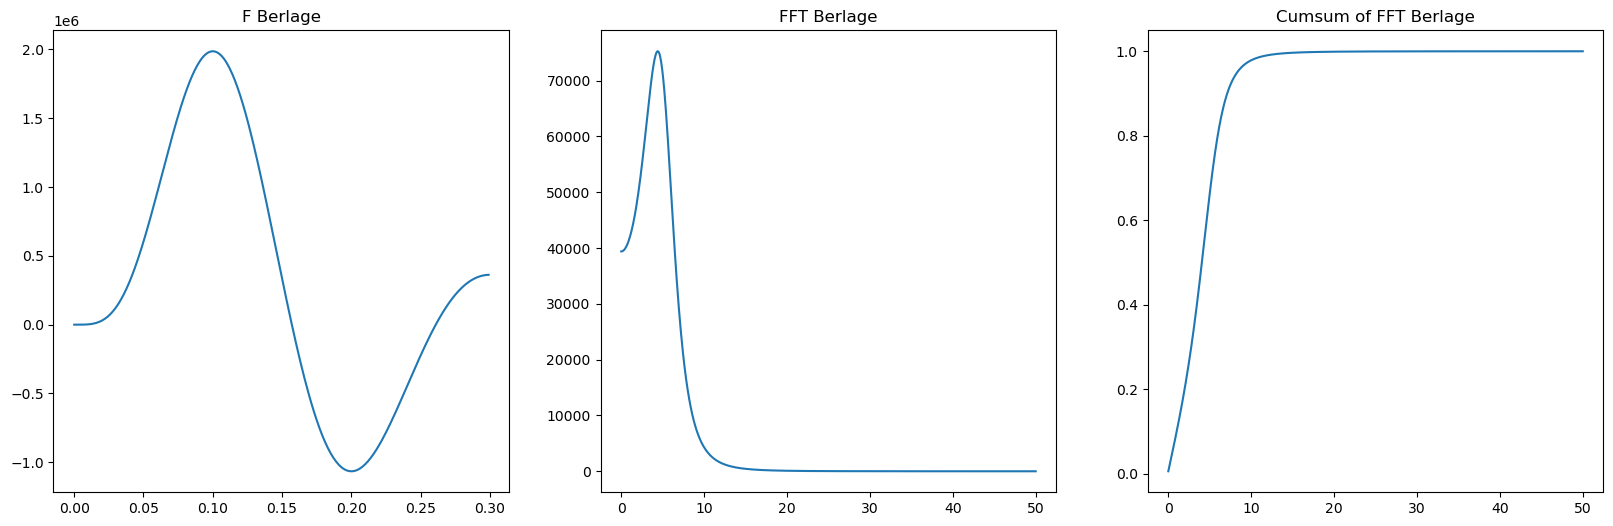

In [ ]:
N = 300
w = 5

times = np.arange(N) / 1000
f_values = F(times, w)

freq_analytical = np.arange(800) / 16
omega_list = 2 * np.pi * freq_analytical
fft_analytical = fft_F(omega_list, w)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(times, f_values)
axs[0].set_title("F Berlage")
axs[1].plot(freq_analytical, np.abs(fft_analytical))
axs[1].set_title("FFT Berlage")
axs[2].plot(freq_analytical, np.abs(fft_analytical).cumsum() / np.abs(fft_analytical).sum())
axs[2].set_title("Cumsum of FFT Berlage")

In [ ]:
fft_analytical = np.abs(fft_analytical)

energy = fft_analytical**2
cumsum = energy.cumsum() / energy.sum()
l = np.argmin(cumsum < 0.05)
r = np.argmax(cumsum > 0.95)
freq_analytical[l], freq_analytical[r], np.log2(freq_analytical[r] / freq_analytical[l])

(0.6875, 6.5, 3.241008099503795)

In [ ]:
f_max = freq_analytical[np.argmax(np.abs(fft_analytical))]
f_aver = (freq_analytical * energy).sum() / energy.sum()
f_max, f_aver

(4.375, 3.8577713186935956)

In [ ]:
v_p / f_max, v_p / f_aver, v_s / f_max , v_s / f_aver

(84.4055938143996, 95.72222986588281, 56.27039587626639, 63.81481991058854)

0.0 6.5


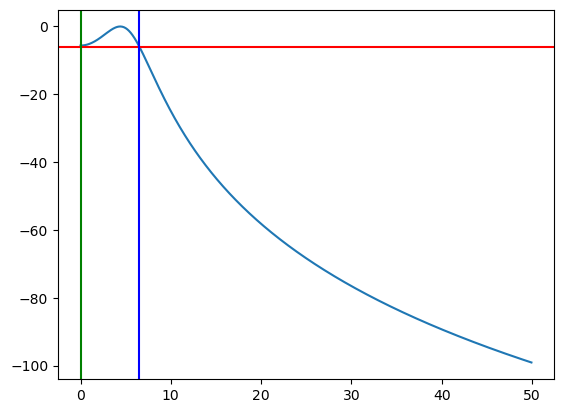

In [ ]:
mag = 20*np.log10(fft_analytical/fft_analytical.max())
plt.plot(freq_analytical,mag)
f_lower, f_upper = freq_analytical[np.argmax(mag > -6)], freq_analytical[::-1][np.argmax(mag[::-1] > -6)]
print(f_lower, f_upper)
plt.axhline(y=-6, color='red')
plt.axvline(x=f_lower, color='green')
plt.axvline(x=f_upper, color='blue')

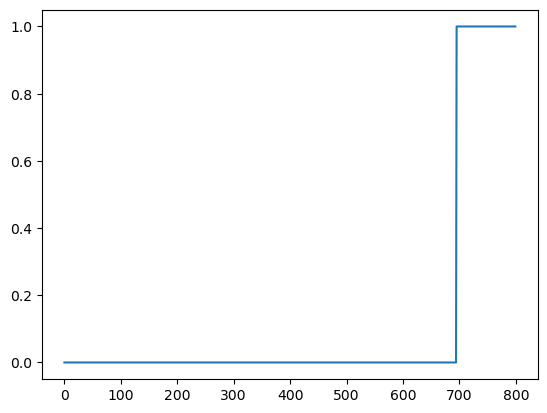

In [ ]:
plt.plot(mag[::-1] > -6)

In [ ]:
mag[np.argmax(mag[::-1] > -6)]

-92.96187010647613

In [ ]:
mag

array([-5.62347149e+00, -5.62143586e+00, -5.61533038e+00, -5.60515937e+00,
       -5.59092999e+00, -5.57265234e+00, -5.55033944e+00, -5.52400725e+00,
       -5.49367480e+00, -5.45936415e+00, -5.42110051e+00, -5.37891232e+00,
       -5.33283129e+00, -5.28289255e+00, -5.22913469e+00, -5.17159995e+00,
       -5.11033428e+00, -5.04538751e+00, -4.97681349e+00, -4.90467026e+00,
       -4.82902020e+00, -4.74993025e+00, -4.66747205e+00, -4.58172221e+00,
       -4.49276251e+00, -4.40068011e+00, -4.30556784e+00, -4.20752442e+00,
       -4.10665478e+00, -4.00307030e+00, -3.89688913e+00, -3.78823649e+00,
       -3.67724498e+00, -3.56405494e+00, -3.44881474e+00, -3.33168114e+00,
       -3.21281961e+00, -3.09240471e+00, -2.97062039e+00, -2.84766036e+00,
       -2.72372837e+00, -2.59903855e+00, -2.47381570e+00, -2.34829556e+00,
       -2.22272503e+00, -2.09736239e+00, -1.97247743e+00, -1.84835160e+00,
       -1.72527802e+00, -1.60356148e+00, -1.48351831e+00, -1.36547624e+00,
       -1.24977409e+00, -

In [ ]:
N = 3
v_p = 376.431142253533
table_n = 1
mult = 100000

R_c = 0.001
demphire_width = 100
b_0 = -(N + 1) * v_p * np.log(R_c)  / 2 / demphire_width
b_x = []
for x in range(0, 110, 10):
    b_x.append(mult * b_0 * (x / demphire_width)**N)
for i in range(len(b_x)):
    print(f"modify table {table_n} cell {i+1} {2} value {b_x[i]:.3f}")    

modify table 1 cell 1 2 value 0.000
modify table 1 cell 2 2 value 5200.588
modify table 1 cell 3 2 value 41604.707
modify table 1 cell 4 2 value 140415.887
modify table 1 cell 5 2 value 332837.659
modify table 1 cell 6 2 value 650073.553
modify table 1 cell 7 2 value 1123327.099
modify table 1 cell 8 2 value 1783801.828
modify table 1 cell 9 2 value 2662701.271
modify table 1 cell 10 2 value 3791228.958
modify table 1 cell 11 2 value 5200588.420


In [ ]:
demphire.plot([25], [10], [9])

NameError: name 'demphire' is not defined

In [ ]:
size_block = 25
order = 9
val = 0
T_exp = 2.95736835
times = demphire.x_ax[size_block][order]
tensor = demphire.tensors_list[size_block][order][val]
eps = np.abs(tensor[-1, :]).max() / 10000
print(f"Величина ошибки: {eps:.2e}")
ind_wave = np.argmax(np.abs(tensor[-1, :]) > eps) 
time_wave = ind_wave / tensor.shape[-1] * T_exp
v_p_exp = L / time_wave
print(f"Индекс прихода волны: {ind_wave}")
print(f"Время прихода волны: {time_wave:.2f} с")
print(f"Скорость пришедшей волны: {v_p_exp:.2f} м/с")

t_intersection = 2 * L / (v_p + v_s)
x_intersection = t_intersection * v_s
print(f"Время пересечения: {t_intersection:.2f} с")
print(f"Расстояние пересечения: {x_intersection:.2f} м")

Величина ошибки: 2.20e-07
Индекс прихода волны: 5021
Время прихода волны: 1.48 с
Скорость пришедшей волны: 336.72 м/с
Время пересечения: 1.62 с
Расстояние пересечения: 400.00 м


In [ ]:
tensor.shape

(21, 10000)

400: 1.1879157188279998 1.7818735782419999
425: 1.26216045125475 1.7076288458152498
450: 1.3364051836814999 1.6333841133884999
475: 1.4106499161082497 1.5591393809617498
500: 1.4848946485349999 1.4848946485349999
525: 1.5591393809617498 1.4106499161082497


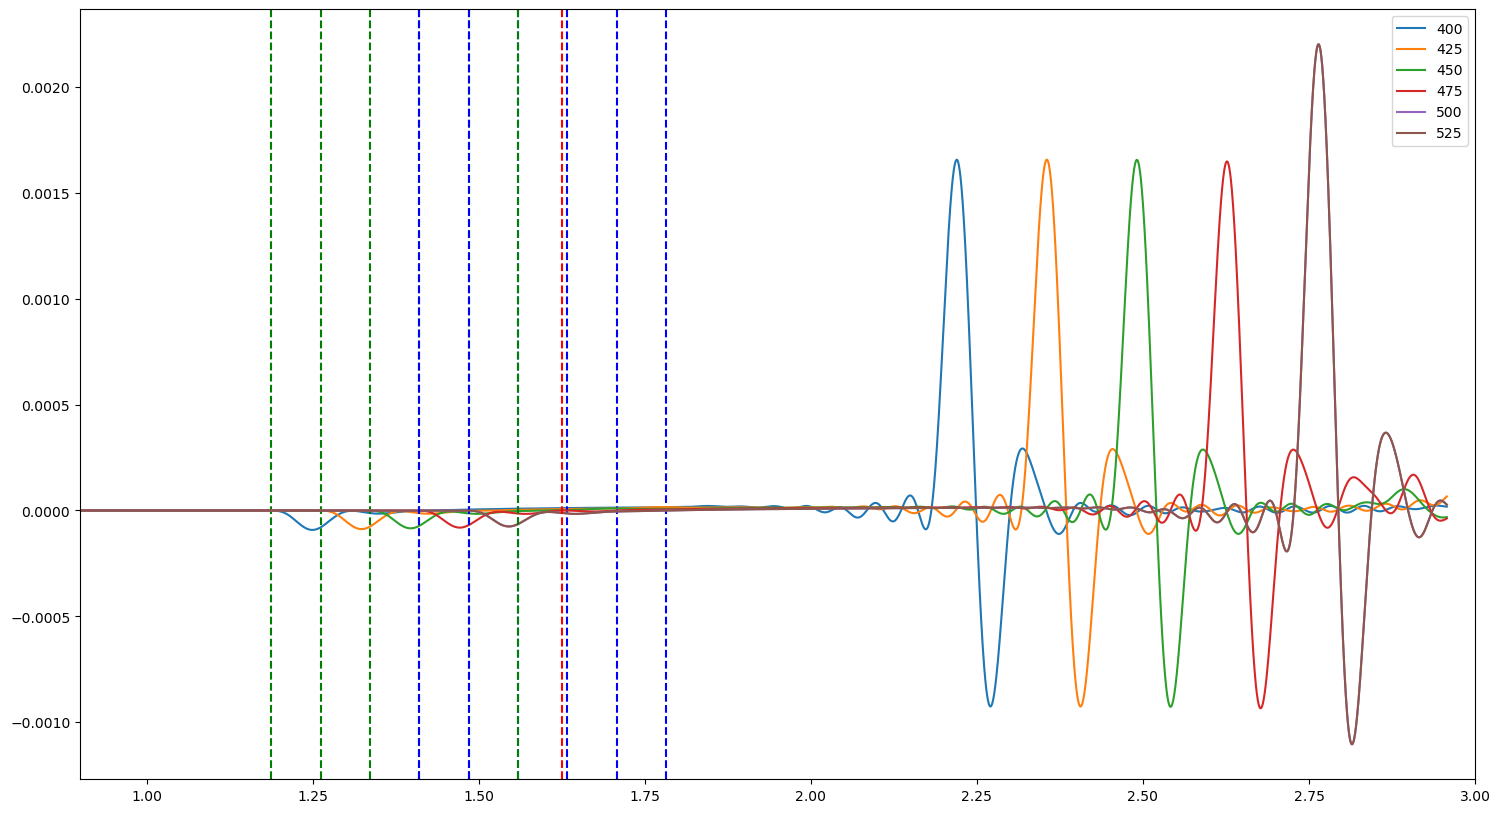

In [ ]:
plt.figure(figsize=(18, 10))
recievers_number = tensor.shape[0]
for reciever in range(recievers_number-6, recievers_number, 1):
    plt.plot(times, tensor[reciever, :], label=f"{reciever * size_block}")
    print(f"{reciever * size_block}: {reciever * size_block / v_p_exp} {(2*L - reciever * size_block) / v_p_exp}")
    plt.axvline(x=reciever * size_block / v_p_exp, color='green', linestyle='--')
    plt.axvline(x=(2*L - reciever * size_block) / v_p_exp, color='blue', linestyle='--')
# plt.xlim(0, t_intersection)
plt.axvline(x=t_intersection, color='red', linestyle='--')
plt.xlim(0.9, 3)
plt.legend()

In [ ]:
reciever = 16
print(f"Расстояние от источника до приемника: {reciever * size_block} м")
t_get = (reciever * size_block / v_p_exp)
ind_get = int(t_get / T_exp * tensor.shape[-1])
print(f"Время прихода волны: {t_get:.2f} с, индекс: {ind_get}")
t_ref = 2 * L / (v_p + v_s)
ind_ref = int(t_ref / T_exp * tensor.shape[-1])
print(f"Время падения волны: {t_ref:.2f} с, индекс: {ind_ref}")
tensor[reciever, int((reciever * size_block / v_p_exp) / T_exp * tensor.shape[-1])], int((reciever * size_block / v_p_exp) / T_exp * tensor.shape[-1])

Расстояние от источника до приемника: 400 м
Время прихода волны: 1.19 с, индекс: 4016
Время падения волны: 1.62 с, индекс: 5494


(-7.4229654e-09, 4016)

In [ ]:
(reciever * size_block / v_p_exp)

1.1879157188279998

In [ ]:
demphire_list = []
prefix_list = [
    'lamb_demphire_R_0_m_1',
    'lamb_demphire_R_000001_m_1',
    'lamb_demphire_R_000001_m_10',
    'lamb_demphire_R_000001_m_1000',
    'lamb_demphire_R_000001_m_100000',
    'lamb_demphire_R_001_m_1',
    'lamb_demphire_R_001_m_10',
    'lamb_demphire_R_001_m_1000',
    'lamb_demphire_R_001_m_100000',
]

for prefix in prefix_list:
    demphire_list.append(ConvergenceCheck(
        path=os.path.join('..', '..', 'exps', 'Lamb_demphire_mult'),
        prefix=prefix,
        cases_dict= { key: [7] for key in [20] },
        verbose = True
    ))
    # demphire.tensors_list[20][7].shape

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4060
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4840
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4958
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4865
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3301
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3019
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3899
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Н

In [ ]:
for var in ['Ux', 'Uy', 'Vx', 'Vy', 'Ax', 'Ay']:
    for i in range(len(demphire_list)):
        # print(f"Max i: {np.max(np.abs(demphire_list[i].tensors_list[20][7][var])):.3e}")
        # print(demphire_list[i].prefix, demphire_list[i].path)
        for j in range(i+1, len(demphire_list)):
            # print(f"Max j: {np.max(np.abs(demphire_list[j].tensors_list[20][7][var])):.3e}")
            if np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum() < 1e-12:
                a = 1
                # print('')
                # print(f"Совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")
            else:
                print(f"{var}: Не совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")

Vx: Не совпадение 0 и 1, разница: 1.653e-10
Vx: Не совпадение 0 и 2, разница: 1.436e-10
Vx: Не совпадение 0 и 3, разница: 1.679e-10
Vx: Не совпадение 0 и 4, разница: 1.667e-10
Vx: Не совпадение 0 и 5, разница: 1.023e-10
Vx: Не совпадение 0 и 6, разница: 1.713e-10
Vx: Не совпадение 0 и 7, разница: 1.251e-10
Vx: Не совпадение 0 и 8, разница: 1.934e-10
Vx: Не совпадение 1 и 2, разница: 1.716e-10
Vx: Не совпадение 1 и 3, разница: 1.340e-10
Vx: Не совпадение 1 и 4, разница: 1.499e-10
Vx: Не совпадение 1 и 5, разница: 1.500e-10
Vx: Не совпадение 1 и 6, разница: 1.300e-10
Vx: Не совпадение 1 и 7, разница: 1.257e-10
Vx: Не совпадение 1 и 8, разница: 1.897e-10
Vx: Не совпадение 2 и 3, разница: 1.440e-10
Vx: Не совпадение 2 и 4, разница: 1.576e-10
Vx: Не совпадение 2 и 5, разница: 1.241e-10
Vx: Не совпадение 2 и 6, разница: 1.569e-10
Vx: Не совпадение 2 и 7, разница: 1.398e-10
Vx: Не совпадение 2 и 8, разница: 1.945e-10
Vx: Не совпадение 3 и 4, разница: 1.506e-10
Vx: Не совпадение 3 и 5, разница

In [ ]:
demphire_list = []
prefix_list = [
    'bigR',
    'zeroR',
]

for prefix in prefix_list:
    demphire_list.append(ConvergenceCheck(
        path=os.path.join('..', '..', 'exps', 'konstantin'),
        prefix=prefix,
        cases_dict= { key: [7] for key in [20] },
        verbose = True
    ))
    print(demphire_list[-1].tensors_list[20][7]['Ux'].shape, demphire_list[-1].tensors_list[20][7]['Ux'].sum())
    # demphire.tensors_list[20][7].shape

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 2016
--------------------
(27, 9103) 5.8721604
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 1948
--------------------
(27, 9103) 5.8721604


In [ ]:
for var in ['Ux', 'Uy', 'Vx', 'Vy', 'Ax', 'Ay']:
    for i in range(len(demphire_list)):
        # print(f"Max i: {np.max(np.abs(demphire_list[i].tensors_list[20][7][var])):.3e}")
        # print(demphire_list[i].prefix, demphire_list[i].path)
        for j in range(i+1, len(demphire_list)):
            # print(f"Max j: {np.max(np.abs(demphire_list[j].tensors_list[20][7][var])):.3e}")
            if np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum() < 1e-12:
                a = 1
                # print('')
                # print(f"Совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")
            else:
                print(f"{var}: Не совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")

Vx: Не совпадение 0 и 1, разница: 1.465e-10
Vy: Не совпадение 0 и 1, разница: 8.608e-11
Ax: Не совпадение 0 и 1, разница: 1.153e-07
Ay: Не совпадение 0 и 1, разница: 1.173e-07


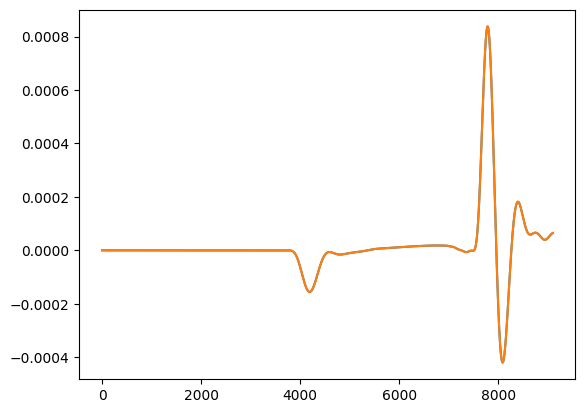

In [ ]:
plt.plot(demphire_list[0].tensors_list[20][7]['Ux'][24])
plt.plot(demphire_list[1].tensors_list[20][7]['Ux'][24])

In [ ]:
for i in range(len(demphire_list)):
    print(demphire_list[i].prefix)

lamb_demphire_R_0
lamb_demphire_R_01
lamb_demphire_R_001
lamb_demphire_R_0001
lamb_demphire_R_00001
lamb_demphire_R_000001


In [ ]:
list(d.values())[0]

[1, 2, 3, 4, 5]

In [ ]:
for x in d.values():
    print(x)

[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]


In [ ]:
d = { 5 : [1, 2, 3, 4, 5],
      10 : [1, 2, 3, 4, 5]
}

In [ ]:
conv_5freq = ConvergenceCheck(
    path=os.path.join('..', '..', 'exps', 'VasiliyTasks'),
    prefix="Task_1",
    cases_dict= { key: [3, 5] for key in [10] },
    verbose = True
)

10_3 uploaded
Найдена величина шага по времени 10 3: 4.12553269e-05
Найдено время работы солвера для 10 3: 1988
--------------------
10_5 uploaded
Найдена величина шага по времени 10 5: 1.75342941e-05
Найдено время работы солвера для 10 5: 8601
--------------------


In [ ]:
for var, tensor in conv_5freq.tensors_list[10][3].items():
    print(var, tensor.shape)

Ux (71, 24240)
Uy (71, 24240)
Vx (71, 24240)
Vy (71, 24240)
Ax (71, 24240)
Ay (71, 24240)
S1 (71, 24240)
S2 (71, 24240)
P (71, 24240)


In [ ]:
conv_5freq.tensors_list[10][3]['S2'].sum()

0.0

(24240,)
(57032,)


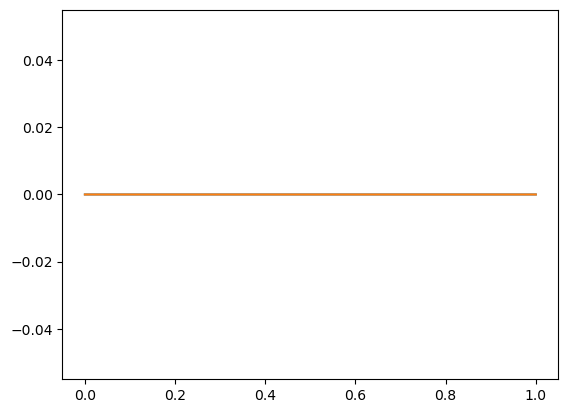

In [ ]:
var = 'P'
reciever = 10
print(conv_5freq.tensors_list[10][3][var][reciever].shape)
print(conv_5freq.tensors_list[10][5][var][reciever].shape)
plt.plot(
    np.arange(conv_5freq.tensors_list[10][3][var].shape[-1]) / conv_5freq.tensors_list[10][3][var].shape[-1],
    conv_5freq.tensors_list[10][3][var][reciever]
)
plt.plot(
    np.arange(conv_5freq.tensors_list[10][5][var].shape[-1]) / conv_5freq.tensors_list[10][5][var].shape[-1],
    conv_5freq.tensors_list[10][5][var][reciever]
)

In [ ]:
b:\Elfimov\Dissertation\exps\Lamb_demphire_nodes\lamb_demphire_mass_0_R_01_20_7

In [ ]:
demphire_list = []
prefix_list = [
    'lamb_demphire_mass_0_R_01',
    'lamb_demphire_mass_1_R_01',
    'lamb_demphire_mass_0_R_0',
    'lamb_demphire_0_R_01'
]

for prefix in prefix_list:
    demphire_list.append(ConvergenceCheck(
        path=os.path.join('..', '..', 'exps', 'Lamb_demphire_nodes'),
        prefix=prefix,
        cases_dict= { key: [7] for key in [20] },
        verbose = True
    ))
    # demphire.tensors_list[20][7].shape

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3247
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 1233
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 828
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3294
--------------------


In [ ]:
for var in ['Ux', 'Uy', 'Vx', 'Vy', 'Ax', 'Ay']:
    # for i in range(len(demphire_list)):
    for i in range(2):
        # print(f"Max i: {np.max(np.abs(demphire_list[i].tensors_list[20][7][var])):.3e}")
        # print(demphire_list[i].prefix, demphire_list[i].path)
        for j in range(i+1, len(demphire_list)):
            # print(f"Max j: {np.max(np.abs(demphire_list[j].tensors_list[20][7][var])):.3e}")
            if np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum() < 1e-12:
                a = 1
                # print('')
                # print(f"Совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")
            else:
                print(f"{var}: Не совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")

Ux: Не совпадение 0 и 1, разница: 1.586e+01
Ux: Не совпадение 0 и 2, разница: 1.187e-12
Ux: Не совпадение 1 и 2, разница: 1.586e+01
Ux: Не совпадение 1 и 3, разница: 1.586e+01
Uy: Не совпадение 0 и 1, разница: 3.117e+01
Uy: Не совпадение 1 и 2, разница: 3.117e+01
Uy: Не совпадение 1 и 3, разница: 3.117e+01
Vx: Не совпадение 0 и 1, разница: 4.113e+02
Vx: Не совпадение 0 и 2, разница: 3.347e-10
Vx: Не совпадение 0 и 3, разница: 2.148e-10
Vx: Не совпадение 1 и 2, разница: 4.113e+02
Vx: Не совпадение 1 и 3, разница: 4.113e+02
Vy: Не совпадение 0 и 1, разница: 6.001e+02
Vy: Не совпадение 0 и 2, разница: 1.650e-10
Vy: Не совпадение 0 и 3, разница: 4.391e-10
Vy: Не совпадение 1 и 2, разница: 6.001e+02
Vy: Не совпадение 1 и 3, разница: 6.001e+02
Ax: Не совпадение 0 и 1, разница: 1.410e+04
Ax: Не совпадение 0 и 2, разница: 1.878e-07
Ax: Не совпадение 0 и 3, разница: 1.914e-07
Ax: Не совпадение 1 и 2, разница: 1.410e+04
Ax: Не совпадение 1 и 3, разница: 1.410e+04
Ay: Не совпадение 0 и 1, разница

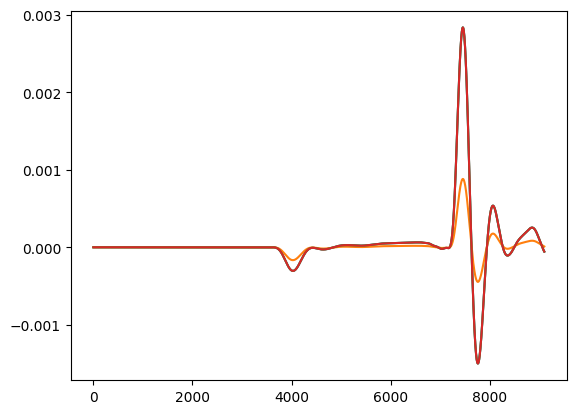

In [ ]:
plt.plot(demphire_list[0].tensors_list[20][7]['Ux'][23])
plt.plot(demphire_list[1].tensors_list[20][7]['Ux'][23])
plt.plot(demphire_list[2].tensors_list[20][7]['Ux'][23])
plt.plot(demphire_list[3].tensors_list[20][7]['Ux'][23])